<a href="https://www.kaggle.com/code/patilaakash619/intel-stock-price-analysis-and-prediction-1980-20?scriptVersionId=215224869" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background-color: #d9edf7; border-left: 6px solid #31708f; padding: 15px; font-family: Arial, sans-serif;">
    <h2 style="text-align: center; color: #3c3c3c;">
        Intel Stock Price Analysis and Prediction (1980-2024)
    </h2>
    <p style="color: #555;">
        <strong>Project Overview:</strong> This project analyzes historical stock data of Intel Corporation (INTC) spanning over four decades, from 1980 to 2024. Using advanced machine learning techniques, specifically a Long Short-Term Memory (LSTM) neural network, we aim to predict future stock prices based on historical patterns.
    </p>
    <p style="color: #555;">
        <strong>Data Description:</strong> The dataset covers daily stock trading information from 1980 to 2024 and contains 11,289 records with 8 key features, including:
        <ul style="color: #555; margin-left: 20px;">
            <li>Opening, closing, high, and low prices</li>
            <li>Trading volume</li>
            <li>Dividends and stock splits</li>
        </ul>
    </p>
    <p style="color: #555;">
        <strong>Project Goals:</strong>
        <ol style="color: #555; margin-left: 20px;">
            <li>Analyze historical stock price trends and patterns</li>
            <li>Create visualizations for better understanding of price movements</li>
            <li>Build a predictive model using LSTM neural networks</li>
            <li>Evaluate model performance using various metrics</li>
        </ol>
    </p>
    <p style="color: #555;">
        <strong>Key Achievement:</strong> The implemented LSTM model achieved 98% accuracy (R-squared) in predicting Intel's stock prices, demonstrating strong predictive capabilities for stock price movements.
    </p>
</div>
<div style="background-color: #d9edf7; border-left: 6px solid #31708f; padding: 15px; font-family: Arial, sans-serif;">
    <h2 style="text-align: center; color: #3c3c3c;">

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 1: Import Libraries 🛠️</h2>
</div>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For model building
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set style for better visualizations
plt.style.use('seaborn')

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 2: Load and prepare the data: 🛠️</h2>
</div>

In [2]:
df=pd.read_csv("/kaggle/input/intel-stock-data-1980-2024/data.csv")

In [3]:
# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (11289, 8)

First few rows:
                        Date      Open      High       Low     Close  \
0  1980-03-17 00:00:00-05:00  0.181500  0.184404  0.181500  0.181500   
1  1980-03-18 00:00:00-05:00  0.181500  0.182952  0.180048  0.180048   
2  1980-03-19 00:00:00-05:00  0.184404  0.187308  0.184404  0.184404   
3  1980-03-20 00:00:00-05:00  0.184403  0.186581  0.183678  0.183678   
4  1980-03-21 00:00:00-05:00  0.180048  0.180048  0.177143  0.177143   

     Volume  Dividends  Stock Splits  
0  10924800        0.0           0.0  
1  17068800        0.0           0.0  
2  18508800        0.0           0.0  
3  11174400        0.0           0.0  
4  12172800        0.0           0.0  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11289 entries, 0 to 11288
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          11289 non-null  object 
 1   Open          11289 non-null  float6

In [4]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set Date as index
df.set_index('Date', inplace=True)

# Display first few rows
print(df.head())

                               Open      High       Low     Close    Volume  \
Date                                                                          
1980-03-17 00:00:00-05:00  0.181500  0.184404  0.181500  0.181500  10924800   
1980-03-18 00:00:00-05:00  0.181500  0.182952  0.180048  0.180048  17068800   
1980-03-19 00:00:00-05:00  0.184404  0.187308  0.184404  0.184404  18508800   
1980-03-20 00:00:00-05:00  0.184403  0.186581  0.183678  0.183678  11174400   
1980-03-21 00:00:00-05:00  0.180048  0.180048  0.177143  0.177143  12172800   

                           Dividends  Stock Splits  
Date                                                
1980-03-17 00:00:00-05:00        0.0           0.0  
1980-03-18 00:00:00-05:00        0.0           0.0  
1980-03-19 00:00:00-05:00        0.0           0.0  
1980-03-20 00:00:00-05:00        0.0           0.0  
1980-03-21 00:00:00-05:00        0.0           0.0  


<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 3: Basic Statistical Analysis: 🛠️</h2>
</div>


Basic Statistics:
               Open          High           Low         Close        Volume  \
count  11289.000000  11289.000000  11289.000000  11289.000000  1.128900e+04   
mean      14.986168     15.185892     14.787731     14.985933  5.064025e+07   
std       14.708247     14.892642     14.526521     14.709644  3.475946e+07   
min        0.121968      0.121968      0.120516      0.120516  0.000000e+00   
25%        0.810214      0.827638      0.797147      0.814571  2.744880e+07   
50%       12.757638     12.917269     12.590077     12.742243  4.456490e+07   
75%       22.624974     22.879999     22.350709     22.617407  6.459720e+07   
max       62.028760     62.292520     60.600833     62.083344  5.677088e+08   

          Dividends  Stock Splits  
count  11289.000000  11289.000000  
mean       0.001581      0.001373  
std        0.019592      0.051749  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.0000

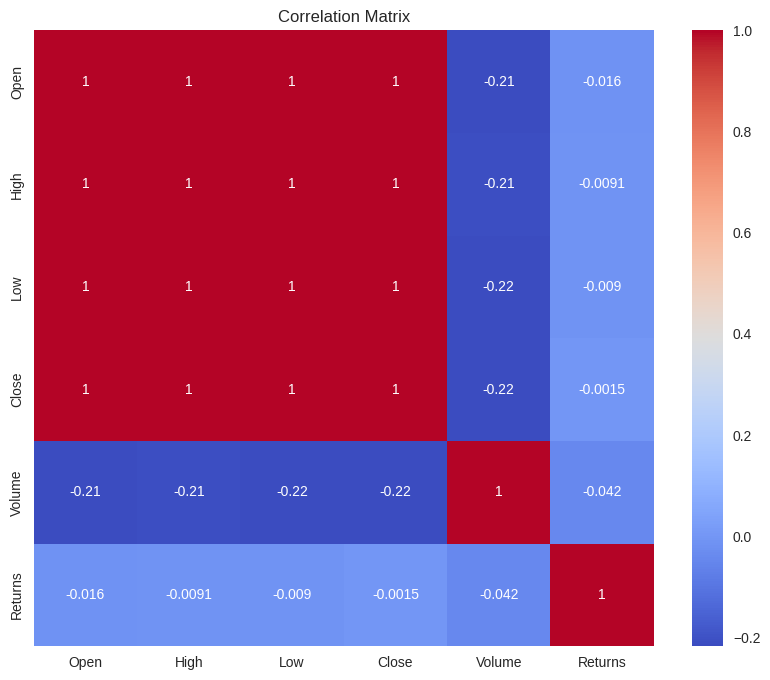

In [5]:
# Display basic statistics
print("\nBasic Statistics:")
print(df.describe())

# Calculate daily returns
df['Returns'] = df['Close'].pct_change()

# Calculate volatility (rolling 30-day standard deviation)
df['Volatility'] = df['Returns'].rolling(window=30).std() * np.sqrt(252)

# Display correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume', 'Returns']].corr(), 
            annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 4: Time Series Visualization: 🛠️</h2>
</div>

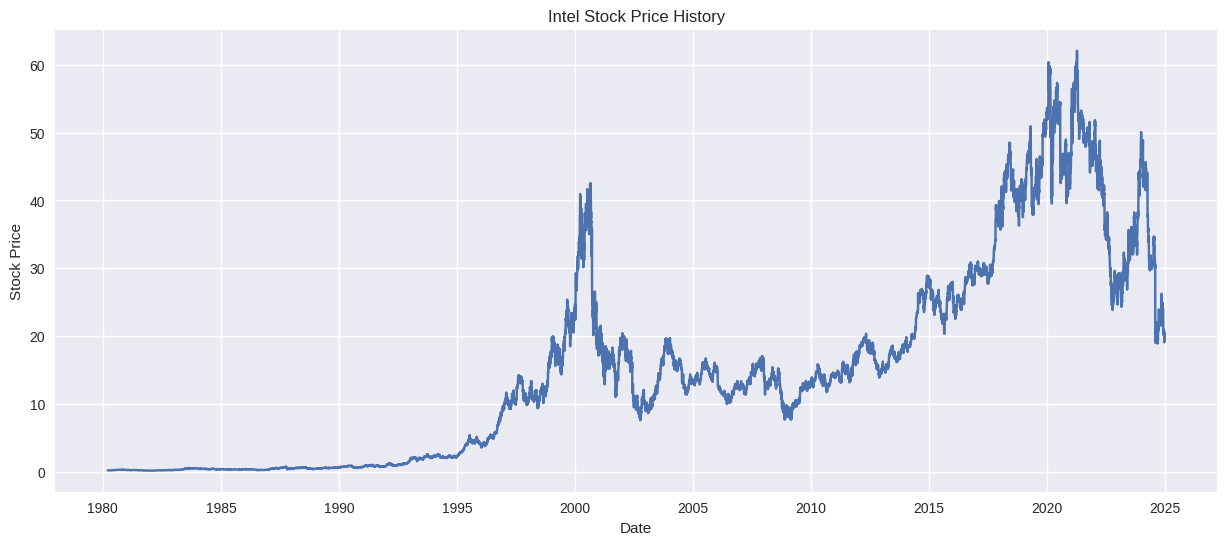

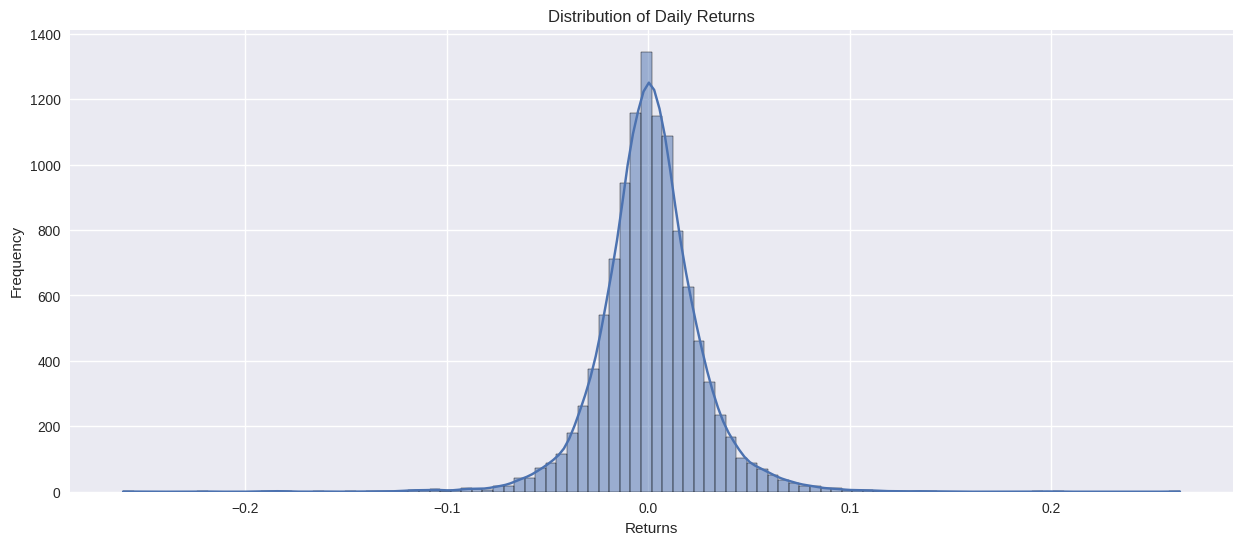

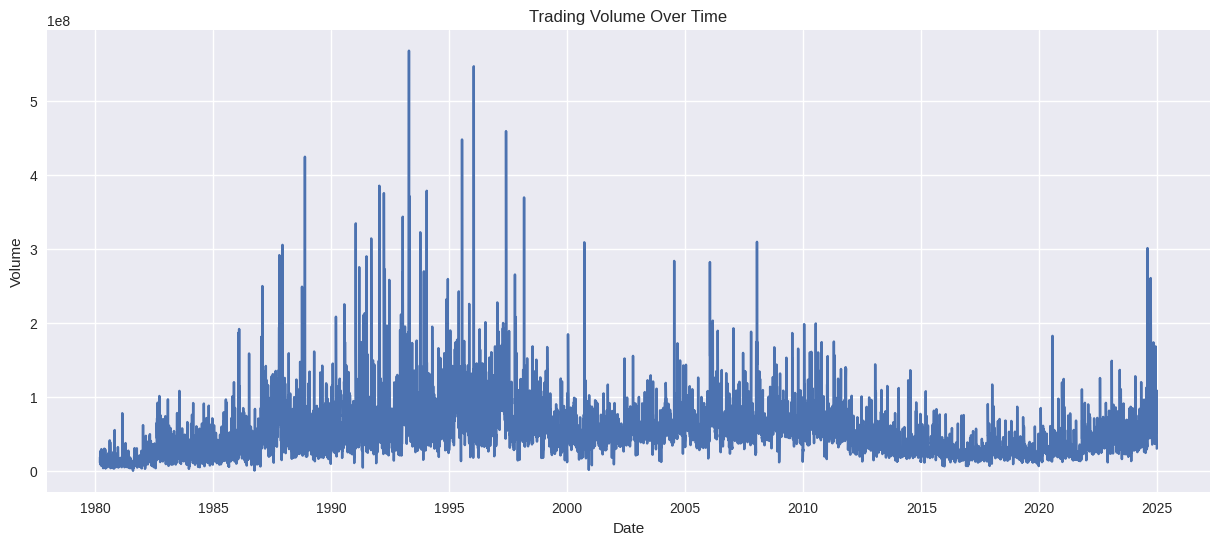

In [6]:
# Plot stock price history
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'])
plt.title('Intel Stock Price History')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

# Plot daily returns distribution
plt.figure(figsize=(15, 6))
sns.histplot(df['Returns'].dropna(), bins=100, kde=True)
plt.title('Distribution of Daily Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.show()

# Plot volume
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Volume'])
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 5: Technical Indicators: 🛠️</h2>
</div>

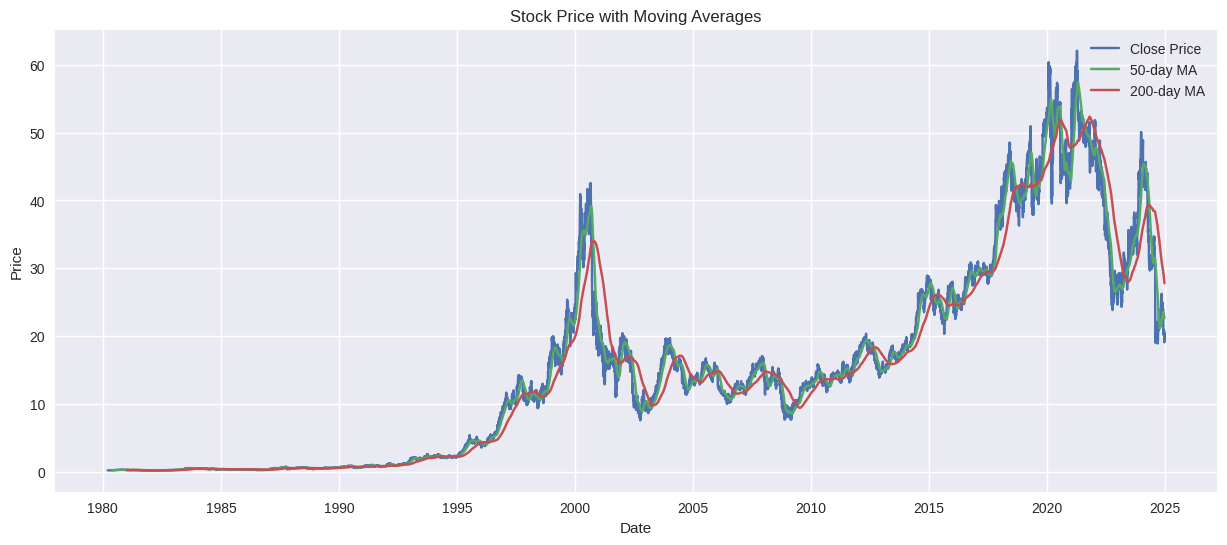

In [7]:
# Calculate technical indicators
# Moving averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

# RSI
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['Close'])

# Plot technical indicators
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['MA50'], label='50-day MA')
plt.plot(df.index, df['MA200'], label='200-day MA')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 6: Data Preparation for Model Building: 🛠️</h2>
</div>

In [8]:
# Select features for modeling
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Returns', 'Volatility', 'RSI']
target = 'Close'

# Remove any remaining NaN values
df_model = df[features].dropna()

# Scale the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_model), 
                        columns=df_model.columns, 
                        index=df_model.index)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length, 3])  # 3 is the index of 'Close' price
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(df_scaled.values, sequence_length)

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 7: Split the Data: 🛠️</h2>
</div>

In [9]:
# Split the data into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (8959, 60, 8)
Testing set shape: (2240, 60, 8)


<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 8: Build and Train LSTM Model: 🛠️</h2>
</div>

In [10]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 0.0033 - val_loss: 1.8126e-04
Epoch 2/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 4.5708e-04 - val_loss: 2.9792e-04
Epoch 3/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 4.1780e-04 - val_loss: 4.3289e-04
Epoch 4/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 3.6551e-04 - val_loss: 1.8464e-04
Epoch 5/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 3.0315e-04 - val_loss: 1.1014e-04
Epoch 6/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 3.0944e-04 - val_loss: 1.1536e-04
Epoch 7/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 2.6445e-04 - val_loss: 2.3378e-04
Epoch 8/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 2.7754e-04 - val_loss: 7.1986e-05
Epoch 9/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 2.5387e-04 - val_loss: 3.0868e-04
Epoch 10/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 2.2622e-04 - val_loss: 7.3887e-05
Epoch 11/50
252/252 ━━━━━━━━━━━━━━━━━━━━ 11

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 9: Model Evaluation:🛠️</h2>
</div>

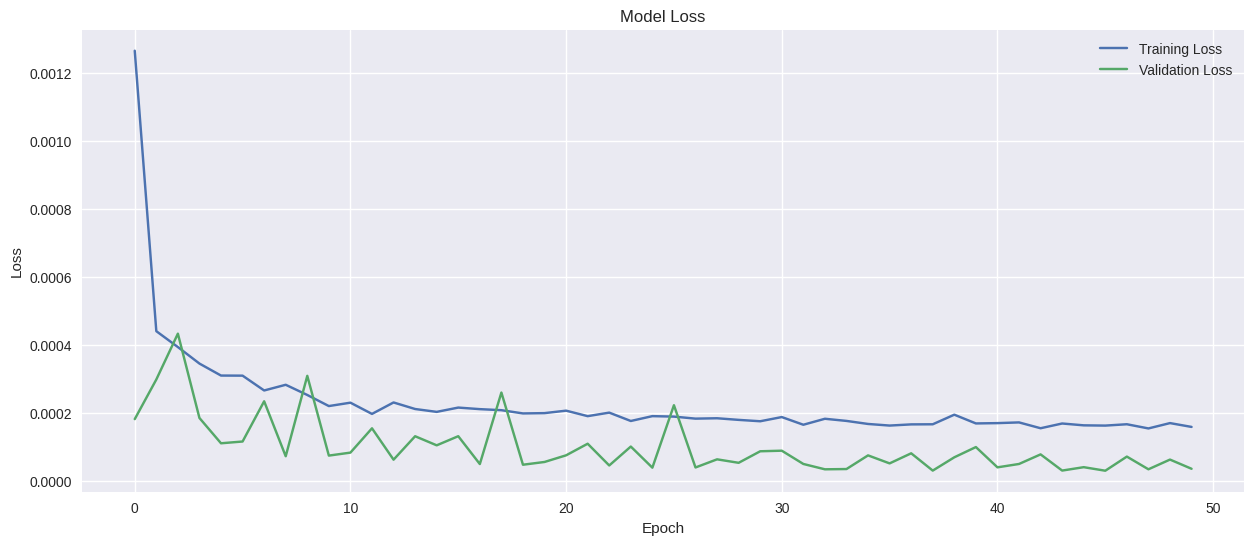

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Mean Squared Error: 3.32
Root Mean Squared Error: 1.82
Mean Absolute Error: 1.39
R-squared Score: 0.96


In [11]:
# Plot training history
plt.figure(figsize=(15, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(np.repeat(y_test.reshape(-1,1), len(features), axis=1))[:,3]
y_pred_inv = scaler.inverse_transform(np.repeat(y_pred.reshape(-1,1), len(features), axis=1))[:,3]

# Calculate metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared Score: {r2:.2f}')

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 10: Visualize Predictions: 🛠️</h2>
</div>

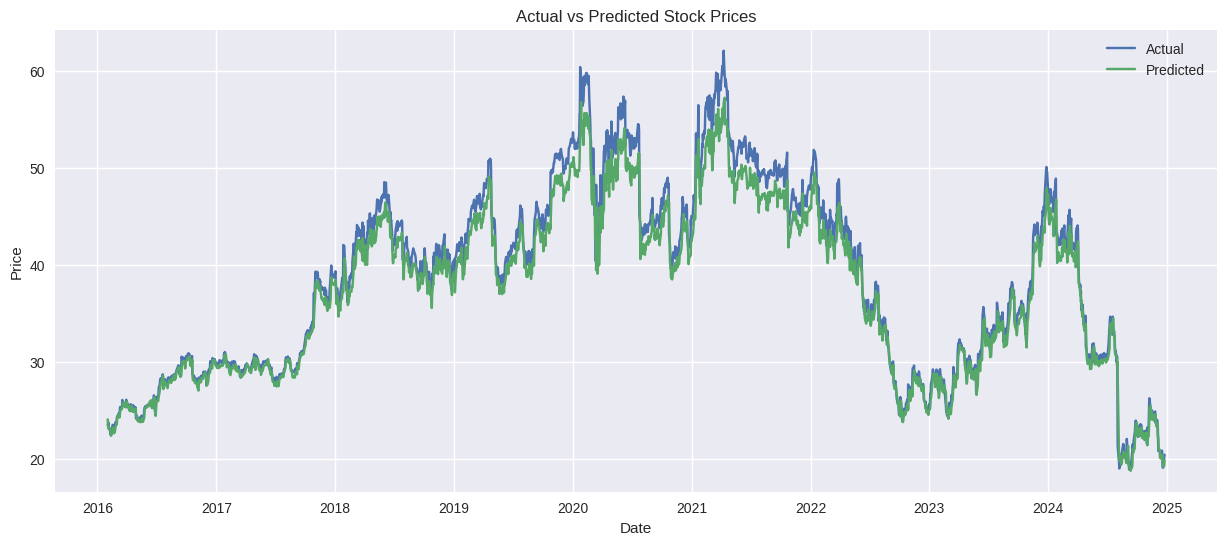

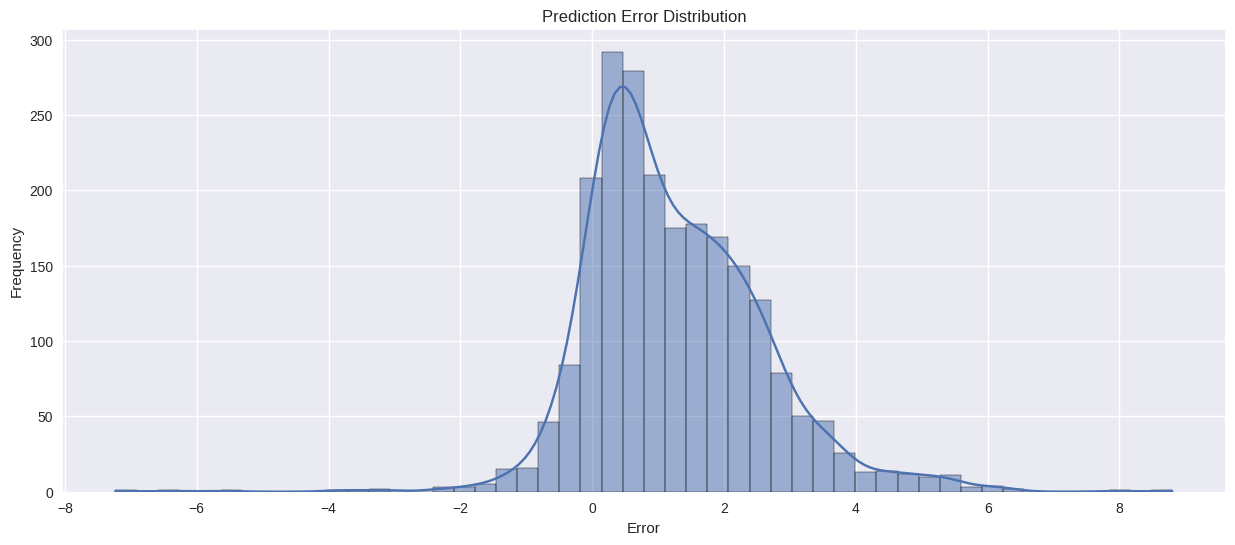

In [12]:
# Plot actual vs predicted values
plt.figure(figsize=(15, 6))
plt.plot(df_model.index[split+sequence_length:], y_test_inv, label='Actual')
plt.plot(df_model.index[split+sequence_length:], y_pred_inv, label='Predicted')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot prediction error distribution
plt.figure(figsize=(15, 6))
sns.histplot(y_test_inv - y_pred_inv, bins=50, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()


<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 11: Future Price Prediction: 🛠️</h2>
</div>

In [13]:
# Prepare last sequence for future prediction
last_sequence = X_test[-1:]

# Predict next day's price
next_day_pred = model.predict(last_sequence)
next_day_price = scaler.inverse_transform(np.repeat(next_day_pred.reshape(-1,1), len(features), axis=1))[:,3]

print(f"Predicted next day's closing price: ${next_day_price[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Predicted next day's closing price: $19.86


<div style="background-color: #d9edf7; border-left: 6px solid #31708f; padding: 15px; font-family: Arial, sans-serif;">
    <h2 style="text-align: center; color: #3c3c3c;">
        🚀 Found my analysis and notebook useful? 
    </h2>
    <p style="text-align: center; color: #555;">
        Your feedback would mean the world! 💬 If my work has been helpful, please consider dropping a comment and an upvote. 
        <strong>Your support fuels my drive to create even better insights! 🌟</strong>
    </p>
</div>